In [32]:
!pip install category_encoders

In [33]:
# Importing Packages
import numpy as np
import pandas as pd 
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from tensorflow.keras import initializers
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
# Importing Data
df_churn = pd.read_csv("Churn_Modelling.csv")

In [35]:
# Data Overview
df_churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [36]:
df_churn.drop(["RowNumber","CustomerId","Surname"],axis = 1,inplace = True)

In [37]:
# One hot encoding
def one_hot_encoding(df,col):
    one_hot_encoder=ce.OneHotEncoder(cols=col,return_df=True,use_cat_names=True)
    df_final = one_hot_encoder.fit_transform(df)
    return df_final

In [38]:
def ordinal_encoding(df,col,mapping):
    ordinal_encoder=ce.OrdinalEncoder(cols=col,return_df=True,mapping=[{'col':col,'mapping':mapping}])
    df_final = ordinal_encoder.fit_transform(df)
    return df_final

In [39]:
df_churn = one_hot_encoding(df_churn,"Geography")
df_churn =  ordinal_encoding(df_churn,"Gender",{"Male":1,"Female":0})

In [40]:
X = df_churn.drop(["Exited"],axis = 1)
Y = df_churn[["Exited"]]

In [41]:
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

In [42]:
# Plotting accuracy of train,test
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

In [52]:
def train_nn(test_ratio,optimizer,epochs,batch_size):
    X_resampled, y_resampled = SMOTE().fit_resample(X, Y)
    X_train, X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = test_ratio,random_state = 27)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get("val_accuracy")>0.88):
                  print("Reached the accuracy required (ie) 90%", logs)
                  self.model.stop_training=True
    callback=myCallback()
    model=tf.keras.Sequential([
                           tf.keras.layers.Dense(512,activation='tanh',input_shape=(X_train.shape[1],)),
                           tf.keras.layers.Dense(256,activation='elu',input_shape=(X_train.shape[1],)),
                           tf.keras.layers.Dropout(0.1),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dropout(0.3), 
                           tf.keras.layers.Dense(56,activation='tanh'),
                           tf.keras.layers.Dropout(0.125),
                           tf.keras.layers.Dense(24,activation='exponential'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
    model.compile(optimizer = optimizer,
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size = batch_size,callbacks=[callback],verbose=2)
    print(f"For {optimizer} with Batch Size {batch_size} \n")
    plot_metric(history,"accuracy")
    
    Y_pred = model.predict(X_test)
    Y_pred = np.round(Y_pred).astype(int)
    sns.heatmap(confusion_matrix(Y_pred,y_test),annot = True)
    model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [53]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

Epoch 1/500


C:\Users\Karan\miniconda3\envs\cpu\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 - 1s - loss: 0.5618 - accuracy: 0.7156 - val_loss: 0.4340 - val_accuracy: 0.7976 - 1s/epoch - 11ms/step
Epoch 2/500


C:\Users\Karan\miniconda3\envs\cpu\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 - 1s - loss: 0.4486 - accuracy: 0.7900 - val_loss: 0.3993 - val_accuracy: 0.8158 - 561ms/epoch - 6ms/step
Epoch 3/500
100/100 - 1s - loss: 0.4228 - accuracy: 0.8038 - val_loss: 0.4039 - val_accuracy: 0.8082 - 587ms/epoch - 6ms/step
Epoch 4/500
100/100 - 1s - loss: 0.4164 - accuracy: 0.8065 - val_loss: 0.3943 - val_accuracy: 0.8145 - 516ms/epoch - 5ms/step
Epoch 5/500
100/100 - 1s - loss: 0.4093 - accuracy: 0.8122 - val_loss: 0.4000 - val_accuracy: 0.8151 - 543ms/epoch - 5ms/step
Epoch 6/500
100/100 - 1s - loss: 0.4087 - accuracy: 0.8089 - val_loss: 0.3723 - val_accuracy: 0.8217 - 612ms/epoch - 6ms/step
Epoch 7/500
100/100 - 1s - loss: 0.4006 - accuracy: 0.8154 - val_loss: 0.3719 - val_accuracy: 0.8302 - 616ms/epoch - 6ms/step
Epoch 8/500
100/100 - 1s - loss: 0.3974 - accuracy: 0.8161 - val_loss: 0.3655 - val_accuracy: 0.8302 - 580ms/epoch - 6ms/step
Epoch 9/500
100/100 - 1s - loss: 0.3956 - accuracy: 0.8196 - val_loss: 0.3678 - val_accuracy: 0.8318 - 548ms/epoch - 5ms/step
Epoc

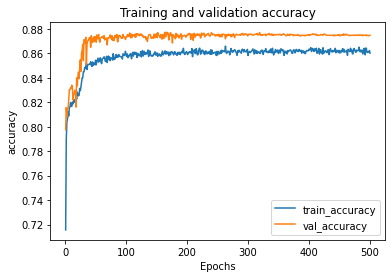

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 512)               6656      
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 56)                7224      
                                                                 
 dropout_26 (Dropout)        (None, 56)               

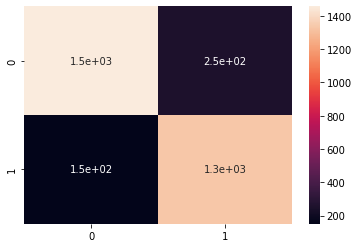

In [54]:
Y_pred = train_nn(0.2,optimizer,500,128)